# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [3]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.65, 0.25], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.65, 0.25], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.55, 0.45], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process


# choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                  "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}
# preprocess_text = TextAugment([0.05, 0.2, 0.2, 0.3, 0.25], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

# choice_probas_test = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.0, "char_delete": 0.2,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                       "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}

# preprocess_text_test = TextAugment([0.1, 0.9], choice_probas_test, fasttext_file="wiki-news-300d-1M-subword.bin")

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


In [4]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

In [5]:


scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# Params

In [ ]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




# BERT Models

## Non Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.851	0.666


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs




## Head Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.05,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval Head Ensemble


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 20
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs

# 0.799	0.657 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.1,
# 0.780	0.634 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.15, 
# 0.806	0.648 gaussian_noise=0.0, dropout=0.02, word_masking_proba=0.1
# 0.803	0.655 gaussian_noise=0.0, dropout=0.1, word_masking_proba=0.1, (0.807	0.657) 0.803	0.653


## Decoder Ensemble

### Train All Params

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.718772 LR = 0.00000348



Epoch =  2 Loss = 0.550060 LR = 0.00000697



Epoch =  3 Loss = 0.498758 LR = 0.00001045



Epoch =  4 Loss = 0.483025 LR = 0.00001393



Epoch =  5 Loss = 0.474293 LR = 0.00001742



Epoch =  6 Loss = 0.468750 LR = 0.00002090



Epoch =  7 Loss = 0.464112 LR = 0.00002439



Epoch =  8 Loss = 0.445096 LR = 0.00002787



Epoch =  9 Loss = 0.433669 LR = 0.00003135



Epoch =  10 Loss = 0.427765 LR = 0.00003484



Epoch =  11 Loss = 0.410222 LR = 0.00003832



Epoch =  12 Loss = 0.407620 LR = 0.00004180



Epoch =  13 Loss = 0.395988 LR = 0.00004529



Epoch =  14 Loss = 0.392119 LR = 0.00004877



Epoch =  15 Loss = 0.388016 LR = 0.00004995



Epoch =  16 Loss = 0.378539 LR = 0.00004970



Epoch =  17 Loss = 0.380119 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.257 0.767     0   1
1      0.350 0.791     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.461,"[0.5391131639480591, 0.46088677644729614]",0,0,0.362,"[0.6375855803489685, 0.3624144196510315]",0,0,0.485,"[0.5150215029716492, 0.48497849702835083]",0,0
1,0.502,"[0.49781566858291626, 0.5021843314170837]",1,1,0.473,"[0.5270142555236816, 0.47298574447631836]",0,1,0.731,"[0.26916807889938354, 0.7308319211006165]",1,0
2,0.667,"[0.33346617221832275, 0.6665338277816772]",1,0,0.685,"[0.3153882324695587, 0.6846117377281189]",1,1,0.484,"[0.5161066055297852, 0.48389342427253723]",0,1
3,0.606,"[0.3939986824989319, 0.6060013175010681]",1,0,0.565,"[0.43538790941238403, 0.5646121501922607]",1,1,0.491,"[0.5088193416595459, 0.4911806881427765]",0,1
4,0.690,"[0.3097067177295685, 0.6902932524681091]",1,1,0.411,"[0.5887421369552612, 0.41125786304473877]",0,0,0.530,"[0.47012901306152344, 0.5298709869384766]",1,1


scores =  {'map': '0.6070', 'acc': '0.5820', 'auc': '0.6408'}
Epoch =  17 Train = 0.793770 Val = 0.640816



Epoch =  18 Loss = 0.363576 LR = 0.00004856



Epoch =  19 Loss = 0.350770 LR = 0.00004768



Epoch =  20 Loss = 0.351472 LR = 0.00004660



Epoch =  21 Loss = 0.350841 LR = 0.00004534



Epoch =  22 Loss = 0.362643 LR = 0.00004389



Epoch =  23 Loss = 0.353840 LR = 0.00004229



Epoch =  24 Loss = 0.353242 LR = 0.00004053



Epoch =  25 Loss = 0.346662 LR = 0.00003863



Epoch =  26 Loss = 0.337099 LR = 0.00003662


Exception for:  keyboard | ' ' ' ' | ['char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  27 Loss = 0.338021 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.116 0.820     0   1
1      0.218 0.804     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.536,"[0.4635389447212219, 0.5364610552787781]",1,0,0.500,"[0.500245213508606, 0.49975472688674927]",0,0,0.638,"[0.3620915412902832, 0.6379084587097168]",1,1
1,0.401,"[0.5989819765090942, 0.40101802349090576]",0,1,0.444,"[0.5563808083534241, 0.4436192214488983]",0,1,0.318,"[0.682303249835968, 0.317696750164032]",0,0
2,0.598,"[0.40168994665145874, 0.5983099937438965]",1,0,0.414,"[0.5861711502075195, 0.4138287901878357]",0,0,0.383,"[0.6168411374092102, 0.383158802986145]",0,0
3,0.426,"[0.5743964910507202, 0.425603449344635]",0,0,0.526,"[0.47432202100753784, 0.5256779789924622]",1,1,0.302,"[0.6977944374084473, 0.30220553278923035]",0,1
4,0.297,"[0.7027177810668945, 0.2972821593284607]",0,0,0.586,"[0.4137776494026184, 0.5862222909927368]",1,1,0.307,"[0.69254469871521, 0.30745524168014526]",0,0


scores =  {'map': '0.6090', 'acc': '0.5840', 'auc': '0.6449'}
Epoch =  27 Train = 0.826394 Val = 0.644920



Epoch =  28 Loss = 0.334243 LR = 0.00003231



Epoch =  29 Loss = 0.337152 LR = 0.00003005



Epoch =  30 Loss = 0.338960 LR = 0.00002774



Epoch =  31 Loss = 0.345512 LR = 0.00002541



Epoch =  32 Loss = 0.327440 LR = 0.00002308



Epoch =  33 Loss = 0.332765 LR = 0.00002076



Epoch =  34 Loss = 0.335312 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.062 0.790     0   1
1      0.118 0.785     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.375,"[0.6246748566627502, 0.37532514333724976]",0,1,0.474,"[0.5260006785392761, 0.4739993214607239]",0,0,0.199,"[0.8013868927955627, 0.19861312210559845]",0,0
1,0.626,"[0.37433922290802, 0.6256607174873352]",1,0,0.252,"[0.7484865188598633, 0.2515134811401367]",0,0,0.613,"[0.38710659742355347, 0.6128933429718018]",1,1
2,0.347,"[0.6533840298652649, 0.34661591053009033]",0,1,0.414,"[0.5856658816337585, 0.41433411836624146]",0,0,0.526,"[0.47387635707855225, 0.526123583316803]",1,1
3,0.405,"[0.5947701930999756, 0.40522974729537964]",0,1,0.372,"[0.6279582381248474, 0.3720417022705078]",0,0,0.180,"[0.8197525143623352, 0.18024751543998718]",0,0
4,0.502,"[0.4975951015949249, 0.5024048089981079]",1,1,0.159,"[0.8406492471694946, 0.1593507081270218]",0,1,0.369,"[0.6312727928161621, 0.3687271773815155]",0,1


scores =  {'map': '0.6057', 'acc': '0.5620', 'auc': '0.6462'}
Epoch =  34 Train = 0.841295 Val = 0.646192



Epoch =  35 Loss = 0.330259 LR = 0.00001626



Epoch =  36 Loss = 0.333742 LR = 0.00001412



Epoch =  37 Loss = 0.334051 LR = 0.00001207



Epoch =  38 Loss = 0.331695 LR = 0.00001013


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  39 Loss = 0.327759 LR = 0.00000832



Epoch =  40 Loss = 0.328073 LR = 0.00000666



Epoch =  41 Loss = 0.324816 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.047 0.775     0   1
1      0.107 0.816     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.418,"[0.5821535587310791, 0.41784635186195374]",0,0,0.316,"[0.6843077540397644, 0.3156922459602356]",0,0,0.355,"[0.6450698375701904, 0.3549301028251648]",0,1
1,0.491,"[0.5089985132217407, 0.4910014569759369]",0,1,0.275,"[0.7253762483596802, 0.2746237814426422]",0,0,0.641,"[0.35865893959999084, 0.6413410305976868]",1,0
2,0.534,"[0.4661112129688263, 0.5338887572288513]",1,0,0.343,"[0.6566886901855469, 0.3433113098144531]",0,0,0.527,"[0.47314882278442383, 0.5268511772155762]",1,1
3,0.407,"[0.592505693435669, 0.40749430656433105]",0,1,0.406,"[0.5940530896186829, 0.40594685077667236]",0,0,0.454,"[0.546270489692688, 0.45372945070266724]",0,0
4,0.444,"[0.5562214255332947, 0.44377854466438293]",0,0,0.351,"[0.6485176086425781, 0.35148242115974426]",0,0,0.200,"[0.8003178238868713, 0.1996820867061615]",0,0


scores =  {'map': '0.6082', 'acc': '0.5580', 'auc': '0.6465'}
Epoch =  41 Train = 0.848161 Val = 0.646512



Epoch =  42 Loss = 0.323047 LR = 0.00000382



Epoch =  43 Loss = 0.329718 LR = 0.00000268



Epoch =  44 Loss = 0.331861 LR = 0.00000172



Epoch =  45 Loss = 0.328100 LR = 0.00000097



Epoch =  46 Loss = 0.329676 LR = 0.00000043



Epoch =  47 Loss = 0.323695 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.791     0   1
1      0.119 0.817     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.330,"[0.6696552634239197, 0.3303447365760803]",0,1,0.314,"[0.686339259147644, 0.31366071105003357]",0,1,0.629,"[0.37136155366897583, 0.6286383867263794]",1,0
1,0.755,"[0.2447725087404251, 0.7552274465560913]",1,1,0.464,"[0.5361583232879639, 0.46384161710739136]",0,0,0.694,"[0.30621734261512756, 0.69378262758255]",1,1
2,0.326,"[0.6737571358680725, 0.3262428343296051]",0,0,0.671,"[0.329273521900177, 0.6707264184951782]",1,1,0.556,"[0.44425448775291443, 0.5557454824447632]",1,1
3,0.382,"[0.6184097528457642, 0.38159021735191345]",0,0,0.534,"[0.46580037474632263, 0.534199595451355]",1,1,0.648,"[0.3519119620323181, 0.6480880379676819]",1,1
4,0.677,"[0.32348841428756714, 0.6765115261077881]",1,0,0.498,"[0.5016240477561951, 0.49837589263916016]",0,1,0.571,"[0.42937171459198, 0.57062828540802]",1,0


scores =  {'map': '0.6114', 'acc': '0.5640', 'auc': '0.6508'}
Epoch =  47 Train = 0.849509 Val = 0.650800



Epoch =  48 Loss = 0.322944 LR = 0.00000000



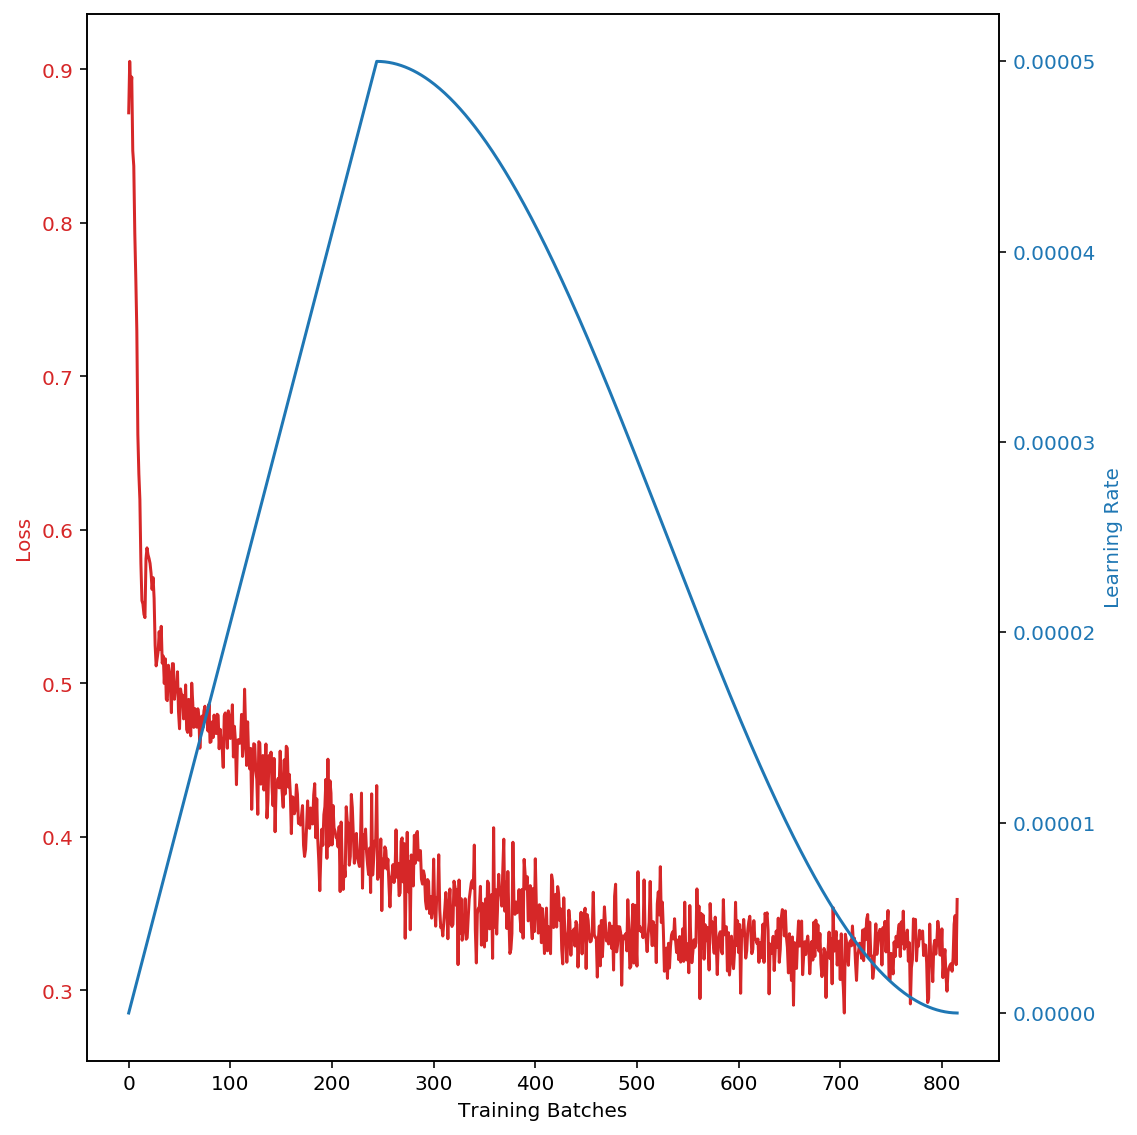

Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.792     0   1
1      0.119 0.818     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.506,"[0.4943177103996277, 0.5056822896003723]",1,0,0.458,"[0.5419405102729797, 0.45805948972702026]",0,1,0.417,"[0.5834930539131165, 0.41650694608688354]",0,0
1,0.480,"[0.519960343837738, 0.48003965616226196]",0,1,0.370,"[0.6301073431968689, 0.36989259719848633]",0,0,0.439,"[0.5610328912734985, 0.4389670789241791]",0,1
2,0.385,"[0.6153403520584106, 0.38465964794158936]",0,0,0.416,"[0.5844233632087708, 0.41557660698890686]",0,0,0.707,"[0.29274964332580566, 0.7072503566741943]",1,0
3,0.326,"[0.6741451621055603, 0.3258548676967621]",0,0,0.499,"[0.5005703568458557, 0.4994296133518219]",0,1,0.682,"[0.3184809982776642, 0.6815189719200134]",1,1
4,0.291,"[0.7093660831451416, 0.2906338572502136]",0,1,0.369,"[0.6306499242782593, 0.3693500757217407]",0,1,0.414,"[0.5855351686477661, 0.4144647717475891]",0,0


scores =  {'map': '0.6114', 'acc': '0.5680', 'auc': '0.6508'}


train   val
mean_or_std metric               
mean        map       0.780 0.611
            accuracy  0.771 0.568
            auc       0.850 0.651
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.835  0.801 0.817 5450.000     0.552  0.728 0.628 250.000
pos     0.668  0.717 0.692 3050.000     0.600  0.408 0.486 250.000

In [31]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.025,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

# 0.854	0.654 0.651 0.646 x2
# MLM = 0.854	0.646
# No focal 0.851	0.647 (0.766	0.556)


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  56 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.693817 LR = 0.00000149



Epoch =  2 Loss = 0.592762 LR = 0.00000298



Epoch =  3 Loss = 0.566228 LR = 0.00000447



Epoch =  4 Loss = 0.555877 LR = 0.00000596



Epoch =  5 Loss = 0.548087 LR = 0.00000746



Epoch =  6 Loss = 0.530008 LR = 0.00000895



Epoch =  7 Loss = 0.513579 LR = 0.00001044



Epoch =  8 Loss = 0.499346 LR = 0.00001193



Epoch =  9 Loss = 0.497599 LR = 0.00001342



Epoch =  10 Loss = 0.505649 LR = 0.00001491



Epoch =  11 Loss = 0.470327 LR = 0.00001640



Epoch =  12 Loss = 0.465575 LR = 0.00001789



Epoch =  13 Loss = 0.456832 LR = 0.00001939



Epoch =  14 Loss = 0.441019 LR = 0.00002088



Epoch =  15 Loss = 0.443088 LR = 0.00002237



Epoch =  16 Loss = 0.447570 LR = 0.00002386



Epoch =  17 Loss = 0.438798 LR = 0.00002500


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.678     0   1
1      0.140 0.718     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.326,"[0.6735860109329224, 0.32641392946243286]",0,1,0.321,"[0.6792784929275513, 0.32072144746780396]",0,0,0.407,"[0.5925323963165283, 0.4074675440788269]",0,1
1,0.552,"[0.4476003646850586, 0.5523996353149414]",1,1,0.395,"[0.6047577261924744, 0.39524227380752563]",0,0,0.111,"[0.888601541519165, 0.11139844357967377]",0,0
2,0.331,"[0.6685856580734253, 0.3314144015312195]",0,1,0.212,"[0.7884982824325562, 0.21150171756744385]",0,1,0.237,"[0.762617826461792, 0.23738214373588562]",0,1
3,0.289,"[0.7113529443740845, 0.28864702582359314]",0,0,0.136,"[0.8640451431274414, 0.13595479726791382]",0,0,0.417,"[0.5832287073135376, 0.4167712926864624]",0,0
4,0.305,"[0.6950263977050781, 0.3049735426902771]",0,1,0.612,"[0.38764163851737976, 0.6123583316802979]",1,1,0.143,"[0.8569101691246033, 0.14308983087539673]",0,0


scores =  {'map': '0.5963', 'acc': '0.5240', 'auc': '0.6231'}
Epoch =  17 Train = 0.784517 Val = 0.623120


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  18 Loss = 0.436490 LR = 0.00002494



Epoch =  19 Loss = 0.414530 LR = 0.00002480



Epoch =  20 Loss = 0.408522 LR = 0.00002458



Epoch =  21 Loss = 0.410029 LR = 0.00002429


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  22 Loss = 0.415834 LR = 0.00002392



Epoch =  23 Loss = 0.433877 LR = 0.00002347



Epoch =  24 Loss = 0.397888 LR = 0.00002296



Epoch =  25 Loss = 0.389034 LR = 0.00002238



Epoch =  26 Loss = 0.400461 LR = 0.00002174



Epoch =  27 Loss = 0.390971 LR = 0.00002103


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.697     0   1
1      0.144 0.758     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.332,"[0.6675203442573547, 0.3324796259403229]",0,0,0.255,"[0.7454895377159119, 0.25451040267944336]",0,0,0.672,"[0.328235387802124, 0.6717645525932312]",1,0
1,0.220,"[0.7803990244865417, 0.21960094571113586]",0,0,0.341,"[0.6588400602340698, 0.3411599397659302]",0,1,0.504,"[0.496135950088501, 0.503864049911499]",1,1
2,0.373,"[0.6265850067138672, 0.37341493368148804]",0,1,0.515,"[0.48470839858055115, 0.5152915716171265]",1,1,0.392,"[0.608165979385376, 0.391834020614624]",0,1
3,0.384,"[0.616107165813446, 0.38389286398887634]",0,0,0.173,"[0.8266434669494629, 0.17335650324821472]",0,0,0.384,"[0.616107165813446, 0.38389286398887634]",0,1
4,0.268,"[0.7320501804351807, 0.2679498493671417]",0,0,0.251,"[0.7491154670715332, 0.2508845031261444]",0,1,0.220,"[0.7799413800239563, 0.22005857527256012]",0,1


scores =  {'map': '0.6022', 'acc': '0.5420', 'auc': '0.6313'}
Epoch =  27 Train = 0.816965 Val = 0.631280



Epoch =  28 Loss = 0.384910 LR = 0.00002027



Epoch =  29 Loss = 0.378276 LR = 0.00001947



Epoch =  30 Loss = 0.372948 LR = 0.00001861



Epoch =  31 Loss = 0.365685 LR = 0.00001772



Epoch =  32 Loss = 0.373271 LR = 0.00001680


Exception for:  keyboard | ' ' ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  33 Loss = 0.368499 LR = 0.00001584



Epoch =  34 Loss = 0.366455 LR = 0.00001487


Proba       Preds    
         min   max   min max
Labels                      
0      0.096 0.747     0   1
1      0.187 0.811     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.291,"[0.7089537382125854, 0.29104623198509216]",0,1,0.512,"[0.4882551431655884, 0.5117448568344116]",1,0,0.241,"[0.7586216926574707, 0.2413783073425293]",0,0
1,0.293,"[0.7069728374481201, 0.2930271625518799]",0,0,0.528,"[0.47187644243240356, 0.5281236171722412]",1,1,0.228,"[0.7722924947738647, 0.22770747542381287]",0,0
2,0.453,"[0.5474585294723511, 0.4525415003299713]",0,1,0.218,"[0.7819173336029053, 0.21808265149593353]",0,0,0.656,"[0.3436698615550995, 0.6563301086425781]",1,1
3,0.144,"[0.8560547828674316, 0.14394524693489075]",0,0,0.453,"[0.5474836826324463, 0.45251625776290894]",0,1,0.457,"[0.5432570576667786, 0.45674291253089905]",0,1
4,0.532,"[0.4680182933807373, 0.5319817066192627]",1,1,0.583,"[0.41734200716018677, 0.5826579332351685]",1,0,0.527,"[0.47262343764305115, 0.5273765325546265]",1,1


scores =  {'map': '0.6094', 'acc': '0.5500', 'auc': '0.6398'}
Epoch =  34 Train = 0.833769 Val = 0.639760



Epoch =  35 Loss = 0.363882 LR = 0.00001388



Epoch =  36 Loss = 0.359039 LR = 0.00001288



Epoch =  37 Loss = 0.369695 LR = 0.00001188



Epoch =  38 Loss = 0.355604 LR = 0.00001089



Epoch =  39 Loss = 0.354957 LR = 0.00000990



Epoch =  40 Loss = 0.353988 LR = 0.00000893



Epoch =  41 Loss = 0.353639 LR = 0.00000798


Proba       Preds    
         min   max   min max
Labels                      
0      0.069 0.801     0   1
1      0.184 0.779     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.388,"[0.6123794317245483, 0.38762056827545166]",0,0,0.603,"[0.3973381519317627, 0.6026618480682373]",1,1,0.657,"[0.3427031636238098, 0.6572967767715454]",1,0
1,0.518,"[0.4818495810031891, 0.5181503295898438]",1,1,0.604,"[0.3959037661552429, 0.6040961742401123]",1,0,0.425,"[0.5750235915184021, 0.42497631907463074]",0,0
2,0.516,"[0.48368215560913086, 0.5163177847862244]",1,1,0.590,"[0.4097056984901428, 0.5902942419052124]",1,1,0.289,"[0.7113732099533081, 0.2886267900466919]",0,0
3,0.434,"[0.5660718083381653, 0.43392816185951233]",0,1,0.624,"[0.37649106979370117, 0.6235089302062988]",1,1,0.353,"[0.6472706198692322, 0.35272935032844543]",0,0
4,0.340,"[0.6600748896598816, 0.339925080537796]",0,1,0.357,"[0.6432638764381409, 0.35673612356185913]",0,0,0.611,"[0.3893555700778961, 0.6106444001197815]",1,1


scores =  {'map': '0.6067', 'acc': '0.5680', 'auc': '0.6445'}
Epoch =  41 Train = 0.844079 Val = 0.644544



Epoch =  42 Loss = 0.347794 LR = 0.00000707



Epoch =  43 Loss = 0.355471 LR = 0.00000618



Epoch =  44 Loss = 0.349166 LR = 0.00000534



Epoch =  45 Loss = 0.353196 LR = 0.00000454



Epoch =  46 Loss = 0.342063 LR = 0.00000380



Epoch =  47 Loss = 0.348893 LR = 0.00000311


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.800     0   1
1      0.150 0.787     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.509,"[0.4913639426231384, 0.5086359977722168]",1,1,0.226,"[0.773829460144043, 0.22617049515247345]",0,0,0.666,"[0.3336986005306244, 0.6663013696670532]",1,1
1,0.571,"[0.4292832314968109, 0.5707167387008667]",1,0,0.489,"[0.510711133480072, 0.489288866519928]",0,1,0.219,"[0.781286358833313, 0.21871358156204224]",0,1
2,0.242,"[0.7576575875282288, 0.24234238266944885]",0,0,0.502,"[0.49778491258621216, 0.5022151470184326]",1,0,0.443,"[0.5574558973312378, 0.4425440728664398]",0,1
3,0.384,"[0.6156567335128784, 0.3843432366847992]",0,0,0.440,"[0.5604334473609924, 0.43956655263900757]",0,1,0.321,"[0.6786003112792969, 0.3213997185230255]",0,1
4,0.190,"[0.809994101524353, 0.19000588357448578]",0,0,0.381,"[0.6188890933990479, 0.38111090660095215]",0,0,0.416,"[0.5836459398269653, 0.41635406017303467]",0,1


scores =  {'map': '0.6059', 'acc': '0.5560', 'auc': '0.6406'}
Epoch =  47 Train = 0.849852 Val = 0.640608



Epoch =  48 Loss = 0.345936 LR = 0.00000248



Epoch =  49 Loss = 0.349147 LR = 0.00000191



Epoch =  50 Loss = 0.343726 LR = 0.00000142



Epoch =  51 Loss = 0.344227 LR = 0.00000099


Proba       Preds    
         min   max   min max
Labels                      
0      0.057 0.801     0   1
1      0.141 0.790     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.306,"[0.6935570240020752, 0.30644291639328003]",0,0,0.320,"[0.6800438165664673, 0.3199561536312103]",0,1,0.402,"[0.5978609323501587, 0.4021390676498413]",0,1
1,0.361,"[0.6394314169883728, 0.3605685234069824]",0,0,0.543,"[0.45663270354270935, 0.5433672666549683]",1,0,0.535,"[0.4645266830921173, 0.5354733467102051]",1,1
2,0.346,"[0.6539775729179382, 0.346022367477417]",0,1,0.434,"[0.5659788846969604, 0.43402108550071716]",0,1,0.205,"[0.794876754283905, 0.2051231861114502]",0,0
3,0.181,"[0.8190778493881226, 0.18092209100723267]",0,0,0.284,"[0.7164740562438965, 0.28352588415145874]",0,1,0.286,"[0.7143470048904419, 0.28565293550491333]",0,0
4,0.513,"[0.4872809648513794, 0.5127189755439758]",1,0,0.352,"[0.6481639742851257, 0.35183602571487427]",0,0,0.366,"[0.634092390537262, 0.36590757966041565]",0,0


scores =  {'map': '0.6103', 'acc': '0.5660', 'auc': '0.6446'}
Epoch =  51 Train = 0.850294 Val = 0.644576



Epoch =  52 Loss = 0.341734 LR = 0.00000064



Epoch =  53 Loss = 0.340628 LR = 0.00000036



Epoch =  54 Loss = 0.344826 LR = 0.00000016


Proba       Preds    
         min   max   min max
Labels                      
0      0.065 0.827     0   1
1      0.159 0.819     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.283,"[0.7166962623596191, 0.28330370783805847]",0,0,0.578,"[0.42221367359161377, 0.5777862071990967]",1,1,0.501,"[0.4988391101360321, 0.5011608600616455]",1,0
1,0.404,"[0.5958144068717957, 0.40418556332588196]",0,1,0.424,"[0.5762948989868164, 0.4237050712108612]",0,1,0.792,"[0.20836807787418365, 0.7916319370269775]",1,0
2,0.111,"[0.8886725902557373, 0.11132741719484329]",0,0,0.320,"[0.6800625324249268, 0.319937527179718]",0,0,0.521,"[0.47883036732673645, 0.5211695432662964]",1,0
3,0.580,"[0.4199727177619934, 0.5800272822380066]",1,1,0.153,"[0.8470019102096558, 0.15299810469150543]",0,0,0.258,"[0.7415542006492615, 0.25844573974609375]",0,1
4,0.402,"[0.5984390377998352, 0.4015609323978424]",0,1,0.426,"[0.5743200778961182, 0.42567992210388184]",0,1,0.628,"[0.37178856134414673, 0.6282113790512085]",1,0


scores =  {'map': '0.6105', 'acc': '0.5680', 'auc': '0.6446'}
Epoch =  54 Train = 0.850712 Val = 0.644576



Epoch =  55 Loss = 0.340601 LR = 0.00000004



Epoch =  56 Loss = 0.342802 LR = 0.00000000



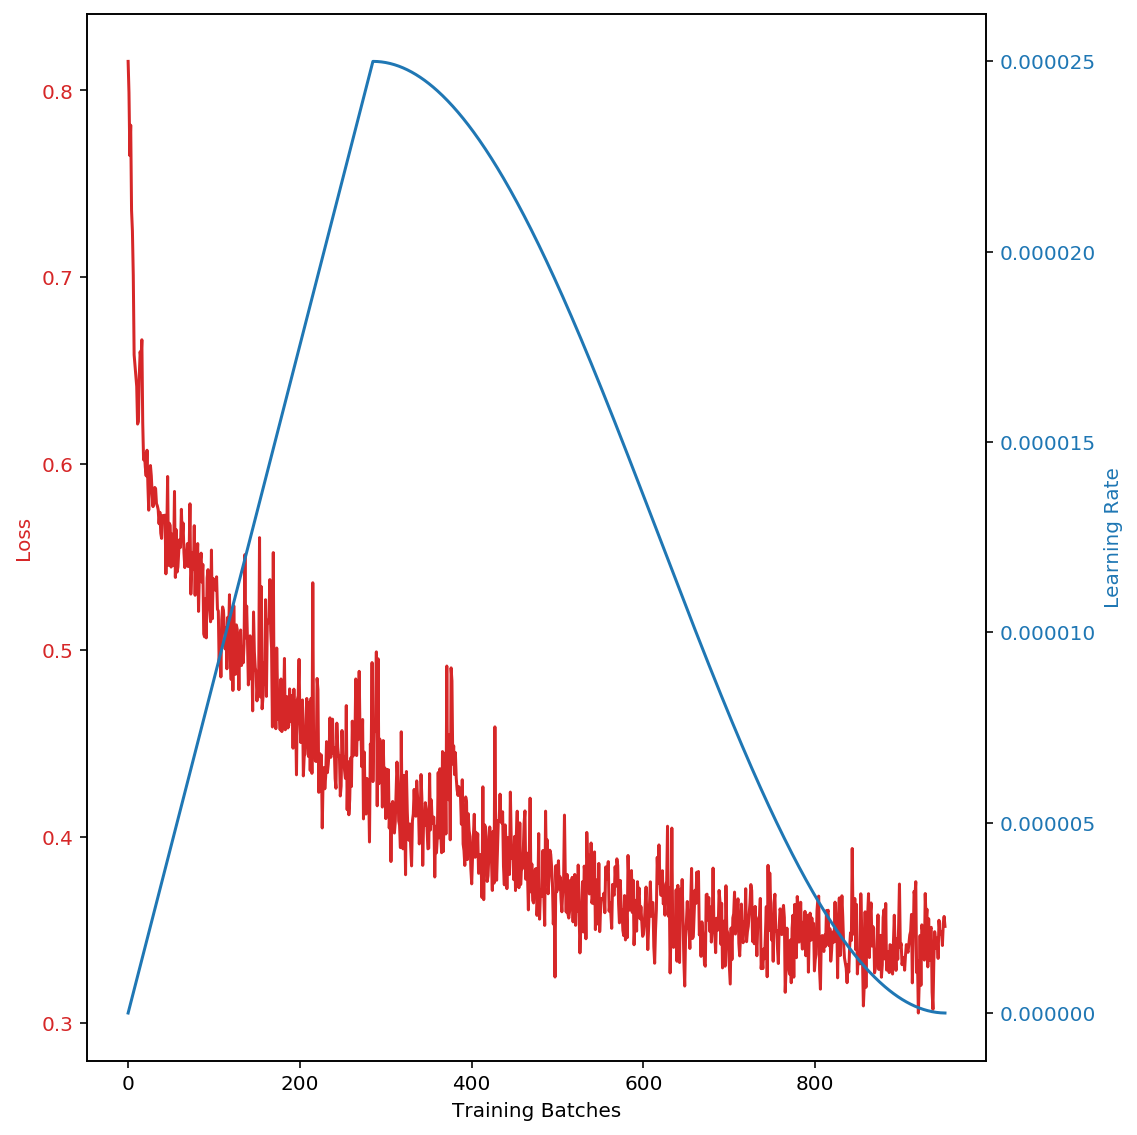

Proba       Preds    
         min   max   min max
Labels                      
0      0.064 0.824     0   1
1      0.157 0.815     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.226,"[0.7740835547447205, 0.22591647505760193]",0,0,0.264,"[0.7355028986930847, 0.2644970715045929]",0,0,0.619,"[0.38055098056793213, 0.6194489598274231]",1,1
1,0.467,"[0.5330854058265686, 0.4669145345687866]",0,1,0.228,"[0.7720579504966736, 0.22794204950332642]",0,0,0.586,"[0.41422411799430847, 0.5857758522033691]",1,1
2,0.425,"[0.5747837424278259, 0.4252162277698517]",0,1,0.459,"[0.5409589409828186, 0.4590410590171814]",0,0,0.399,"[0.600562572479248, 0.3994373679161072]",0,1
3,0.522,"[0.47813206911087036, 0.5218679308891296]",1,0,0.266,"[0.7335094213485718, 0.26649054884910583]",0,1,0.434,"[0.5657378435134888, 0.43426206707954407]",0,0
4,0.375,"[0.6249487400054932, 0.37505120038986206]",0,0,0.594,"[0.4062751531600952, 0.5937248468399048]",1,1,0.428,"[0.571652889251709, 0.428347110748291]",0,1


scores =  {'map': '0.6101', 'acc': '0.5620', 'auc': '0.6444'}


train   val
mean_or_std metric               
mean        map       0.777 0.610
            accuracy  0.761 0.562
            auc       0.851 0.644
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.846  0.767 0.804 5450.000     0.550  0.684 0.610 250.000
pos     0.643  0.750 0.692 3050.000     0.582  0.440 0.501 250.000

In [32]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/4,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 28
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r3, p3 = results, prfs
results
prfs

# 0.853	0.655 (0.765	0.570)
# 0.863	0.651 (0.778	0.570)


### Train Head First

In [15]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.8, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  12 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.698163 LR = 0.00002787



Epoch =  2 Loss = 0.610687 LR = 0.00005574


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  3 Loss = 0.564301 LR = 0.00008361



Epoch =  4 Loss = 0.547213 LR = 0.00009941



Epoch =  5 Loss = 0.539098 LR = 0.00009321



Epoch =  6 Loss = 0.498471 LR = 0.00008105



Epoch =  7 Loss = 0.476651 LR = 0.00006461



Epoch =  8 Loss = 0.472601 LR = 0.00004616



Epoch =  9 Loss = 0.455975 LR = 0.00002824



Epoch =  10 Loss = 0.449115 LR = 0.00001331



Epoch =  11 Loss = 0.445885 LR = 0.00000345



Epoch =  12 Loss = 0.447857 LR = 0.00000000



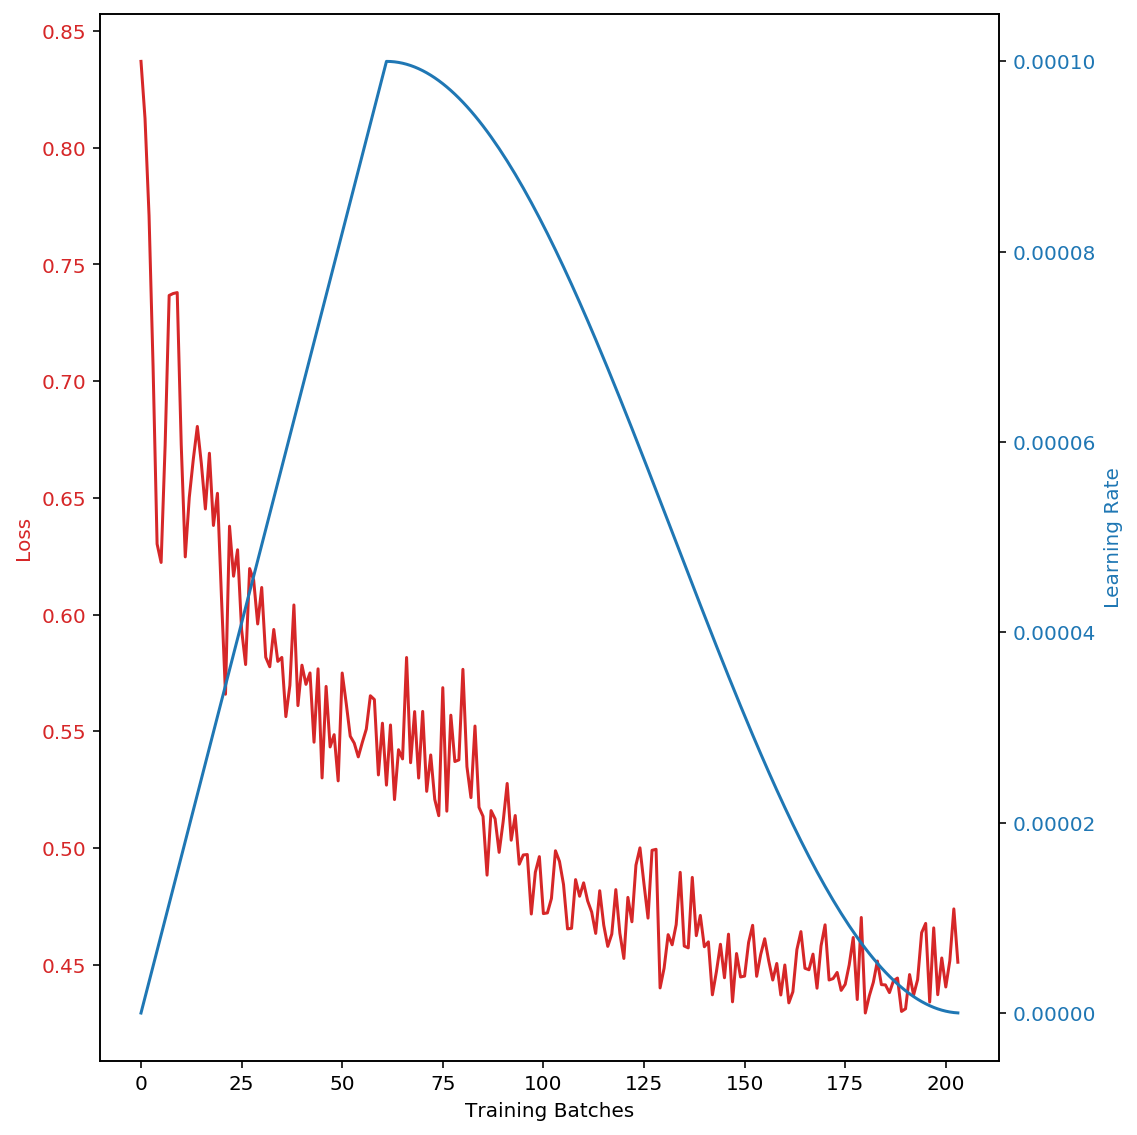

Proba       Preds    
         min   max   min max
Labels                      
0      0.224 0.689     0   1
1      0.302 0.684     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.440,"[0.5600281953811646, 0.43997180461883545]",0,0,0.462,"[0.5377947092056274, 0.4622052311897278]",0,1,0.535,"[0.4647163450717926, 0.535283625125885]",1,0
1,0.527,"[0.47334885597229004, 0.52665114402771]",1,0,0.652,"[0.34750404953956604, 0.6524959206581116]",1,1,0.525,"[0.4751954674720764, 0.5248045325279236]",1,1
2,0.462,"[0.5384514331817627, 0.46154844760894775]",0,0,0.634,"[0.36551433801651, 0.63448566198349]",1,1,0.349,"[0.6513362526893616, 0.34866371750831604]",0,1
3,0.539,"[0.4612864851951599, 0.5387135148048401]",1,0,0.446,"[0.5539846420288086, 0.446015328168869]",0,0,0.503,"[0.49675869941711426, 0.503241240978241]",1,0
4,0.559,"[0.4406222105026245, 0.5593777894973755]",1,1,0.363,"[0.637136697769165, 0.3628632426261902]",0,1,0.224,"[0.776429295539856, 0.22357064485549927]",0,0


scores =  {'map': '0.5765', 'acc': '0.5440', 'auc': '0.5954'}


train   val
mean_or_std metric               
mean        map       0.575 0.576
            accuracy  0.676 0.544
            auc       0.701 0.595
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.736  0.772 0.754 5450.000     0.532  0.724 0.614 250.000
pos     0.554  0.506 0.529 3050.000     0.569  0.364 0.444 250.000

Autocast =  True Epochs =  44 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.440692 LR = 0.00000228



Epoch =  2 Loss = 0.448242 LR = 0.00000455



Epoch =  3 Loss = 0.449790 LR = 0.00000683



Epoch =  4 Loss = 0.444035 LR = 0.00000911


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  5 Loss = 0.439586 LR = 0.00001138



Epoch =  6 Loss = 0.437501 LR = 0.00001366



Epoch =  7 Loss = 0.434087 LR = 0.00001594



Epoch =  8 Loss = 0.449522 LR = 0.00001821



Epoch =  9 Loss = 0.440972 LR = 0.00002049



Epoch =  10 Loss = 0.433771 LR = 0.00002277



Epoch =  11 Loss = 0.425660 LR = 0.00002504



Epoch =  12 Loss = 0.428260 LR = 0.00002732



Epoch =  13 Loss = 0.420916 LR = 0.00002960



Epoch =  14 Loss = 0.418422 LR = 0.00002995



Epoch =  15 Loss = 0.413541 LR = 0.00002974


Proba       Preds    
         min   max   min max
Labels                      
0      0.095 0.759     0   1
1      0.175 0.788     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.434,"[0.5658445358276367, 0.4341554641723633]",0,0,0.350,"[0.6500784158706665, 0.3499215543270111]",0,0,0.478,"[0.5221807956695557, 0.47781914472579956]",0,0
1,0.552,"[0.4483357071876526, 0.5516642928123474]",1,1,0.319,"[0.6811969876289368, 0.31880301237106323]",0,0,0.425,"[0.5747038722038269, 0.4252960681915283]",0,0
2,0.410,"[0.5895922183990479, 0.41040778160095215]",0,1,0.268,"[0.7323227524757385, 0.2676772177219391]",0,0,0.319,"[0.6811969876289368, 0.31880301237106323]",0,0
3,0.306,"[0.6939027905464172, 0.3060971796512604]",0,1,0.213,"[0.7874017953872681, 0.21259811520576477]",0,1,0.523,"[0.47696393728256226, 0.523036003112793]",1,1
4,0.590,"[0.40975308418273926, 0.5902469158172607]",1,0,0.303,"[0.6974825859069824, 0.3025173842906952]",0,0,0.497,"[0.5026798844337463, 0.49732011556625366]",0,1


scores =  {'map': '0.5961', 'acc': '0.5640', 'auc': '0.6318'}
Epoch =  15 Train = 0.792931 Val = 0.631792



Epoch =  16 Loss = 0.420019 LR = 0.00002938



Epoch =  17 Loss = 0.405640 LR = 0.00002888



Epoch =  18 Loss = 0.405621 LR = 0.00002822



Epoch =  19 Loss = 0.407913 LR = 0.00002743



Epoch =  20 Loss = 0.402340 LR = 0.00002652



Epoch =  21 Loss = 0.398287 LR = 0.00002548


Proba       Preds    
         min   max   min max
Labels                      
0      0.070 0.767     0   1
1      0.168 0.784     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.581,"[0.41883033514022827, 0.581169605255127]",1,1,0.420,"[0.5795414447784424, 0.4204585552215576]",0,1,0.361,"[0.638921856880188, 0.36107805371284485]",0,0
1,0.160,"[0.8401798605918884, 0.15982010960578918]",0,0,0.210,"[0.7901769876480103, 0.20982296764850616]",0,0,0.409,"[0.591200590133667, 0.4087993800640106]",0,0
2,0.406,"[0.5943543314933777, 0.4056456685066223]",0,1,0.637,"[0.36305516958236694, 0.6369447708129883]",1,0,0.186,"[0.8137969970703125, 0.1862029731273651]",0,1
3,0.244,"[0.7559787631034851, 0.24402114748954773]",0,0,0.348,"[0.6523950695991516, 0.3476049304008484]",0,1,0.701,"[0.2991531789302826, 0.700846791267395]",1,1
4,0.364,"[0.635712742805481, 0.36428719758987427]",0,0,0.298,"[0.7022269368171692, 0.2977730333805084]",0,1,0.424,"[0.5763265490531921, 0.42367345094680786]",0,0


scores =  {'map': '0.6044', 'acc': '0.5580', 'auc': '0.6431'}
Epoch =  21 Train = 0.817534 Val = 0.643136



Epoch =  22 Loss = 0.396305 LR = 0.00002433



Epoch =  23 Loss = 0.385896 LR = 0.00002309



Epoch =  24 Loss = 0.395279 LR = 0.00002176



Epoch =  25 Loss = 0.391971 LR = 0.00002036



Epoch =  26 Loss = 0.387429 LR = 0.00001891



Epoch =  27 Loss = 0.388222 LR = 0.00001742



Epoch =  28 Loss = 0.383288 LR = 0.00001590



Epoch =  29 Loss = 0.387954 LR = 0.00001437



Epoch =  30 Loss = 0.380945 LR = 0.00001285



Epoch =  31 Loss = 0.389995 LR = 0.00001135


Proba       Preds    
         min   max   min max
Labels                      
0      0.050 0.781     0   1
1      0.152 0.791     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.555,"[0.44478946924209595, 0.555210530757904]",1,1,0.310,"[0.68982994556427, 0.3101699948310852]",0,0,0.523,"[0.4766729772090912, 0.5233269929885864]",1,1
1,0.188,"[0.8118669986724854, 0.18813297152519226]",0,0,0.286,"[0.713894248008728, 0.2861056923866272]",0,0,0.165,"[0.8349292278289795, 0.16507075726985931]",0,1
2,0.235,"[0.7646346092224121, 0.2353653460741043]",0,0,0.547,"[0.45318207144737244, 0.5468178987503052]",1,1,0.423,"[0.5770710706710815, 0.42292889952659607]",0,0
3,0.369,"[0.6308833956718445, 0.3691166043281555]",0,0,0.451,"[0.5489939451217651, 0.4510060250759125]",0,0,0.518,"[0.48181474208831787, 0.5181852579116821]",1,1
4,0.436,"[0.5642609596252441, 0.43573904037475586]",0,1,0.525,"[0.4746493995189667, 0.5253506302833557]",1,0,0.311,"[0.6893054246902466, 0.3106945753097534]",0,0


scores =  {'map': '0.6101', 'acc': '0.5480', 'auc': '0.6469'}
Epoch =  31 Train = 0.839995 Val = 0.646928



Epoch =  32 Loss = 0.378076 LR = 0.00000989



Epoch =  33 Loss = 0.375039 LR = 0.00000848



Epoch =  34 Loss = 0.382650 LR = 0.00000714



Epoch =  35 Loss = 0.373364 LR = 0.00000588



Epoch =  36 Loss = 0.379001 LR = 0.00000472



Epoch =  37 Loss = 0.379256 LR = 0.00000366



Epoch =  38 Loss = 0.378879 LR = 0.00000272



Epoch =  39 Loss = 0.382094 LR = 0.00000191



Epoch =  40 Loss = 0.370486 LR = 0.00000123



Epoch =  41 Loss = 0.374447 LR = 0.00000070


Proba       Preds    
         min   max   min max
Labels                      
0      0.048 0.813     0   1
1      0.149 0.826     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.577,"[0.42271703481674194, 0.5772830247879028]",1,0,0.375,"[0.6248845458030701, 0.37511542439460754]",0,1,0.590,"[0.41003209352493286, 0.5899678468704224]",1,0
1,0.342,"[0.6576443314552307, 0.3423556685447693]",0,0,0.594,"[0.4061635732650757, 0.5938364267349243]",1,1,0.686,"[0.31434130668640137, 0.6856586933135986]",1,1
2,0.357,"[0.642616868019104, 0.357383131980896]",0,0,0.461,"[0.5391397476196289, 0.4608602523803711]",0,1,0.653,"[0.3467215597629547, 0.6532784104347229]",1,0
3,0.557,"[0.4425234794616699, 0.5574765205383301]",1,1,0.796,"[0.20413032174110413, 0.7958696484565735]",1,0,0.557,"[0.4425234794616699, 0.5574765205383301]",1,0
4,0.648,"[0.352477103471756, 0.6475228667259216]",1,1,0.652,"[0.3475119471549988, 0.6524879932403564]",1,0,0.269,"[0.7306421399116516, 0.269357830286026]",0,0


scores =  {'map': '0.6112', 'acc': '0.5660', 'auc': '0.6494'}
Epoch =  41 Train = 0.846625 Val = 0.649360



Epoch =  42 Loss = 0.373179 LR = 0.00000031



Epoch =  43 Loss = 0.371874 LR = 0.00000008



Epoch =  44 Loss = 0.373762 LR = 0.00000000



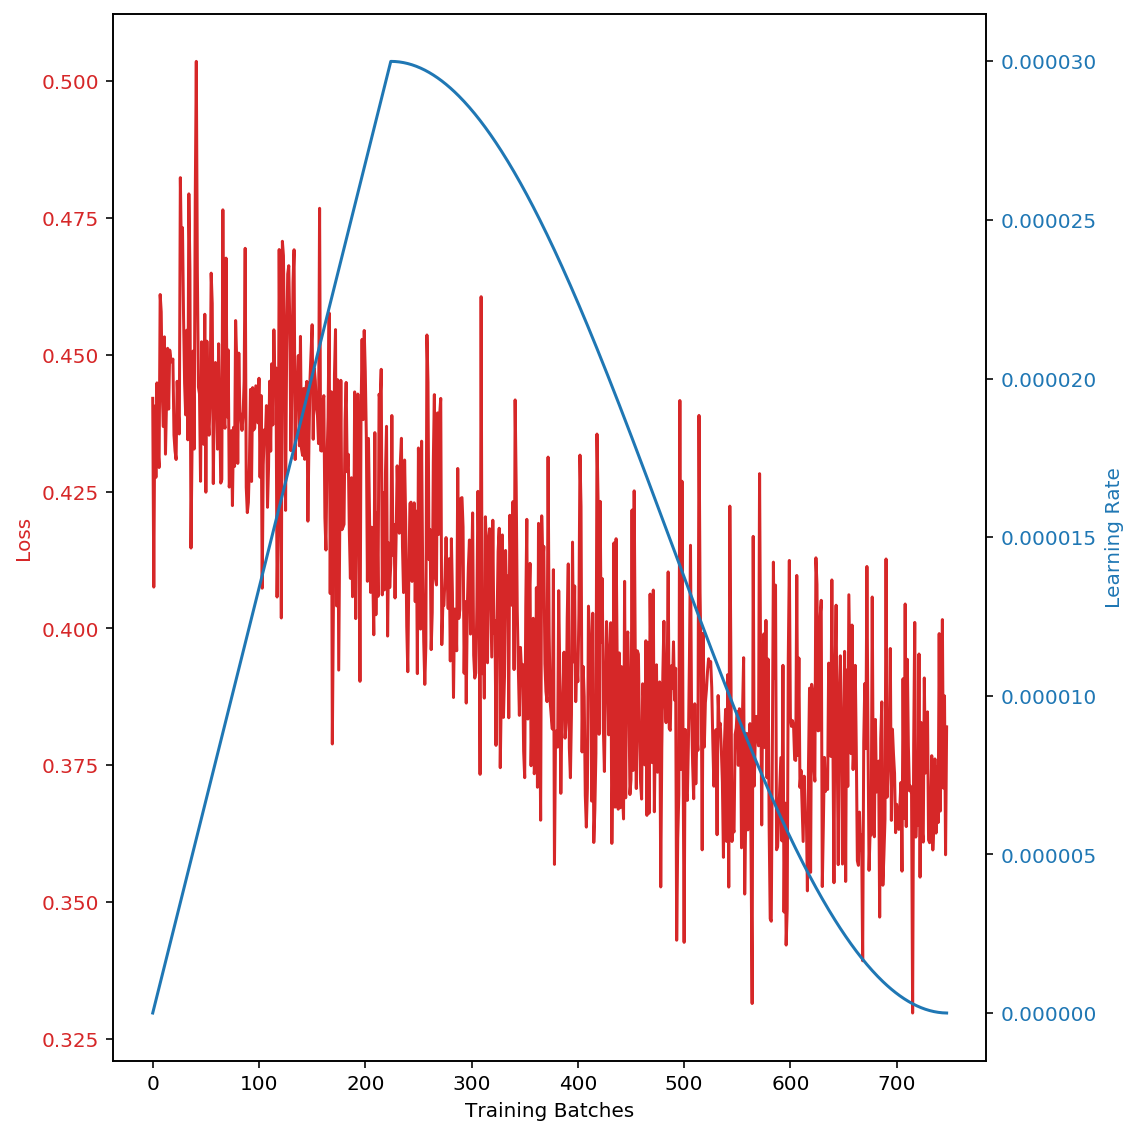

Proba       Preds    
         min   max   min max
Labels                      
0      0.048 0.815     0   1
1      0.151 0.829     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.562,"[0.43762263655662537, 0.5623773336410522]",1,1,0.400,"[0.6003308892250061, 0.3996691107749939]",0,0,0.353,"[0.6466624736785889, 0.35333752632141113]",0,1
1,0.487,"[0.5126946568489075, 0.48730531334877014]",0,1,0.350,"[0.6502174735069275, 0.3497825264930725]",0,1,0.419,"[0.580513596534729, 0.4194864332675934]",0,1
2,0.484,"[0.5159483551979065, 0.4840516448020935]",0,0,0.401,"[0.5989184379577637, 0.40108156204223633]",0,0,0.281,"[0.7185267210006714, 0.2814732491970062]",0,0
3,0.305,"[0.6949018239974976, 0.30509814620018005]",0,0,0.411,"[0.5887417793273926, 0.4112582504749298]",0,1,0.554,"[0.44639623165130615, 0.5536037087440491]",1,1
4,0.469,"[0.5311353802680969, 0.4688646197319031]",0,0,0.586,"[0.41383257508277893, 0.5861674547195435]",1,1,0.275,"[0.7251416444778442, 0.27485835552215576]",0,1


scores =  {'map': '0.6114', 'acc': '0.5660', 'auc': '0.6497'}


train   val
mean_or_std metric               
mean        map       0.772 0.611
            accuracy  0.770 0.566
            auc       0.847 0.650
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.827  0.812 0.819 5450.000     0.548  0.752 0.634 250.000
pos     0.674  0.696 0.685 3050.000     0.605  0.380 0.467 250.000

In [16]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.1,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
results
prfs

adamw_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 24
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 21, 31, 41, 46, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False,
)
r4, p4 = results, prfs
results
prfs

# 0.848	0.656 (0.767	0.570) # 24/8
# 0.841	0.652 (0.765	0.578) # 22/8
# 0.852	0.652 (0.771	0.564) # 26/8
# 0.848	0.655 (0.769	0.574) # 24/10
# 0.846	0.659 (0.767	0.574) 24/6 0.843	0.660 (0.763	0.582)
# 0.844	0.660 (0.764	0.574) 24/5
# 0.849	0.654 (0.767	0.576) 24/4


## Multi-eval decoder ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=preprocess_text_test, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/10,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/10,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/10,
                    "finetune": True
                }
            }
        },
    },
    "final_layer": {
        "lr": optimizer_params["lr"]
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.02,
                              dropout=0.1,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=64,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.01,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[19, 27, 37, 41, 46, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=10, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs


# Predict

In [12]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.8, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=False,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Doing Special split for FB 
 Train Labels = 0    5040
1    2640
Name: label, dtype: int64 Test Labels = 1    660
0    660
Name: label, dtype: int64
Autocast =  True Epochs =  12 Divisor = 2 Examples = 3840 Batch Size =  256
Training Samples =  7680 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.635044 LR = 0.00002778



Epoch =  2 Loss = 0.554910 LR = 0.00005556



Epoch =  3 Loss = 0.528611 LR = 0.00008333



Epoch =  4 Loss = 0.487135 LR = 0.00009944



Epoch =  5 Loss = 0.461981 LR = 0.00009330



Epoch =  6 Loss = 0.451704 LR = 0.00008117


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  7 Loss = 0.423187 LR = 0.00006474



Epoch =  8 Loss = 0.437617 LR = 0.00004626



Epoch =  9 Loss = 0.411960 LR = 0.00002831



Epoch =  10 Loss = 0.405348 LR = 0.00001335



Epoch =  11 Loss = 0.400932 LR = 0.00000346



Epoch =  12 Loss = 0.396802 LR = 0.00000000



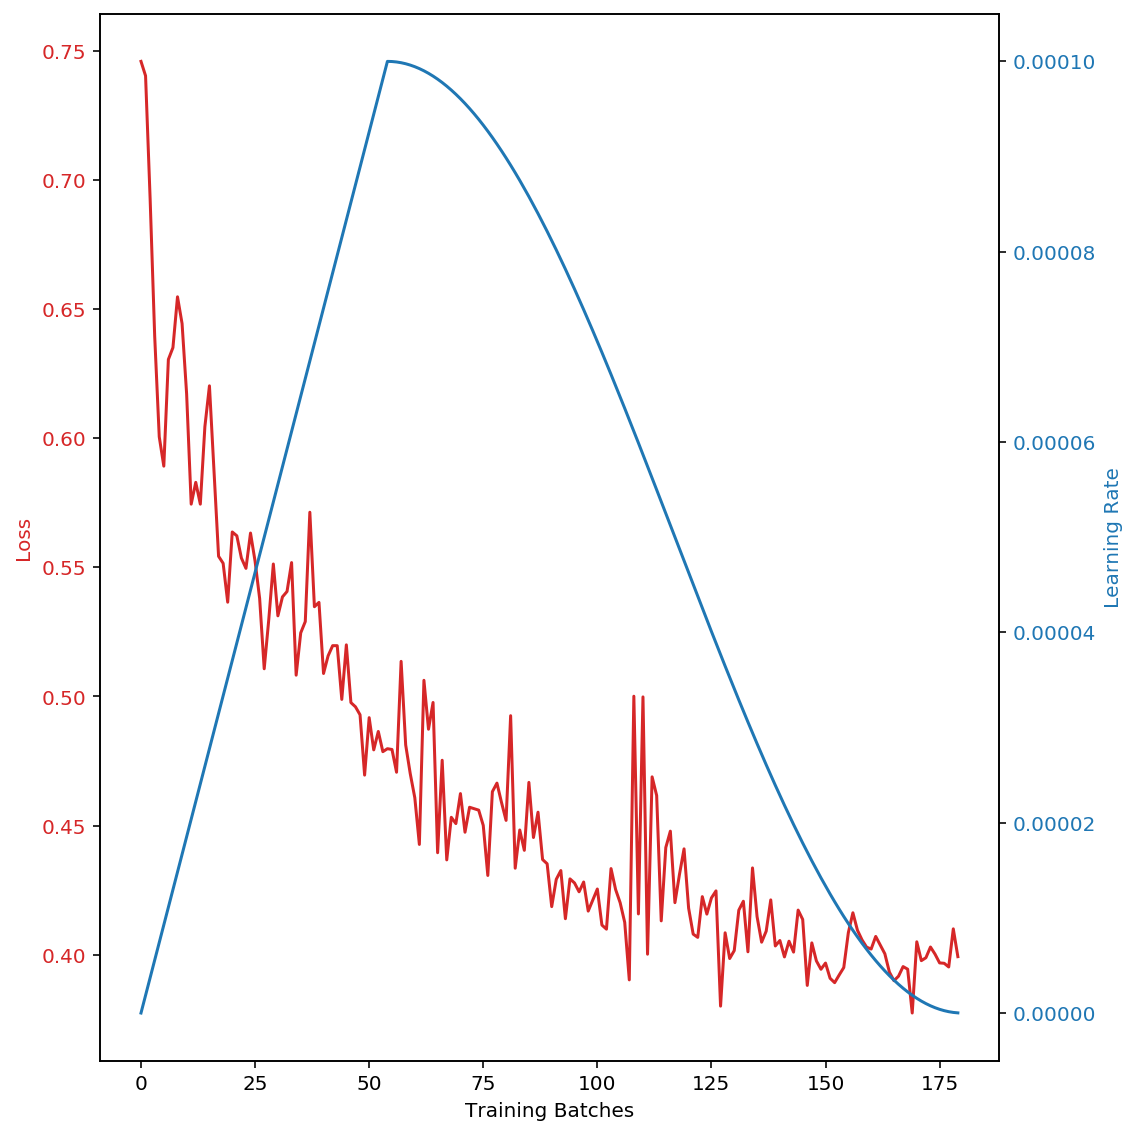

Proba       Preds    
         min   max   min max
Labels                      
0      0.296 0.652     0   1
1      0.280 0.681     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.648,"[0.3517899513244629, 0.6482100486755371]",1,0,0.583,"[0.41690793633461, 0.5830920934677124]",1,0,0.479,"[0.5208192467689514, 0.4791806936264038]",0,1
1,0.390,"[0.6101359724998474, 0.3898639976978302]",0,1,0.474,"[0.526256799697876, 0.4737432301044464]",0,1,0.454,"[0.5461055040359497, 0.4538944959640503]",0,0
2,0.479,"[0.5208645462989807, 0.4791354537010193]",0,1,0.440,"[0.55988609790802, 0.4401138424873352]",0,0,0.464,"[0.5362622737884521, 0.4637376666069031]",0,1
3,0.560,"[0.4400448203086853, 0.5599551796913147]",1,1,0.449,"[0.5510838627815247, 0.44891613721847534]",0,0,0.445,"[0.5548695921897888, 0.4451303780078888]",0,1
4,0.349,"[0.6510116457939148, 0.3489883244037628]",0,0,0.467,"[0.5332916975021362, 0.46670830249786377]",0,0,0.422,"[0.5784708857536316, 0.42152902483940125]",0,0


scores =  {'map': '0.6725', 'acc': '0.6212', 'auc': '0.6750'}


train   val
mean_or_std metric               
mean        map       0.561 0.672
            accuracy  0.682 0.621
            auc       0.702 0.675
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.746  0.780 0.763 5040.000     0.590  0.791 0.676 660.000
pos     0.540  0.494 0.516 2640.000     0.683  0.452 0.544 660.000

In [13]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)





Autocast =  True Epochs =  48 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1



Epoch =  1 Loss = 0.392415 LR = 0.00000208



Epoch =  2 Loss = 0.392204 LR = 0.00000417



Epoch =  3 Loss = 0.399773 LR = 0.00000625



Epoch =  4 Loss = 0.393814 LR = 0.00000834



Epoch =  5 Loss = 0.393116 LR = 0.00001042



Epoch =  6 Loss = 0.394382 LR = 0.00001251



Epoch =  7 Loss = 0.390573 LR = 0.00001459



Epoch =  8 Loss = 0.387173 LR = 0.00001668



Epoch =  9 Loss = 0.384511 LR = 0.00001876



Epoch =  10 Loss = 0.385773 LR = 0.00002085



Epoch =  11 Loss = 0.386432 LR = 0.00002293



Epoch =  12 Loss = 0.391181 LR = 0.00002502



Epoch =  13 Loss = 0.378950 LR = 0.00002710



Epoch =  14 Loss = 0.377906 LR = 0.00002919



Epoch =  15 Loss = 0.370075 LR = 0.00002998


Proba       Preds    
         min   max   min max
Labels                      
0      0.167 0.710     0   1
1      0.191 0.738     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.373,"[0.6271550059318542, 0.37284499406814575]",0,0,0.324,"[0.6760467290878296, 0.323953241109848]",0,0,0.382,"[0.6183886528015137, 0.38161131739616394]",0,0
1,0.738,"[0.26153719425201416, 0.7384628057479858]",1,1,0.340,"[0.6598351001739502, 0.3401649296283722]",0,0,0.253,"[0.7466261386871338, 0.2533738911151886]",0,0
2,0.200,"[0.7996913194656372, 0.2003086507320404]",0,0,0.473,"[0.5268348455429077, 0.4731650948524475]",0,0,0.512,"[0.48776566982269287, 0.5122343301773071]",1,0
3,0.343,"[0.6565786004066467, 0.3434213399887085]",0,1,0.307,"[0.6930299997329712, 0.3069700002670288]",0,0,0.543,"[0.45674288272857666, 0.5432571172714233]",1,1
4,0.326,"[0.6744529008865356, 0.3255470395088196]",0,0,0.440,"[0.5603311657905579, 0.43966883420944214]",0,1,0.289,"[0.7111675143241882, 0.28883248567581177]",0,0


scores =  {'map': '0.6180', 'acc': '0.5380', 'auc': '0.6444'}
Epoch =  15 Train = 0.745651 Val = 0.644384



Epoch =  16 Loss = 0.379846 LR = 0.00002983



Epoch =  17 Loss = 0.386465 LR = 0.00002956



Epoch =  18 Loss = 0.366984 LR = 0.00002915



Epoch =  19 Loss = 0.363568 LR = 0.00002863



Epoch =  20 Loss = 0.362365 LR = 0.00002798



Epoch =  21 Loss = 0.361474 LR = 0.00002723



Epoch =  22 Loss = 0.359878 LR = 0.00002636



Epoch =  23 Loss = 0.357272 LR = 0.00002540



Epoch =  24 Loss = 0.353340 LR = 0.00002434



Epoch =  25 Loss = 0.359773 LR = 0.00002321



Epoch =  26 Loss = 0.355494 LR = 0.00002200



Epoch =  27 Loss = 0.348721 LR = 0.00002073



Epoch =  28 Loss = 0.353562 LR = 0.00001941



Epoch =  29 Loss = 0.352797 LR = 0.00001806


Exception for:  keyboard | ? | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  30 Loss = 0.343354 LR = 0.00001667



Epoch =  31 Loss = 0.347991 LR = 0.00001527



Epoch =  32 Loss = 0.344435 LR = 0.00001387



Epoch =  33 Loss = 0.345828 LR = 0.00001248



Epoch =  34 Loss = 0.343969 LR = 0.00001111


Proba       Preds    
         min   max   min max
Labels                      
0      0.106 0.702     0   1
1      0.144 0.786     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.432,"[0.5683119893074036, 0.43168801069259644]",0,0,0.222,"[0.7781249284744263, 0.22187504172325134]",0,0,0.508,"[0.4923991560935974, 0.5076007843017578]",1,0
1,0.144,"[0.8558209538459778, 0.14417904615402222]",0,0,0.319,"[0.6805868744850159, 0.31941312551498413]",0,0,0.484,"[0.5159904956817627, 0.4840095043182373]",0,1
2,0.479,"[0.5213177800178528, 0.47868216037750244]",0,1,0.432,"[0.5682731866836548, 0.4317268133163452]",0,0,0.582,"[0.417581707239151, 0.5824183225631714]",1,0
3,0.465,"[0.5354835391044617, 0.46451646089553833]",0,1,0.638,"[0.36191806197166443, 0.6380819082260132]",1,1,0.368,"[0.631956934928894, 0.3680430054664612]",0,1
4,0.472,"[0.5280370712280273, 0.47196292877197266]",0,0,0.397,"[0.6033707857131958, 0.3966292142868042]",0,1,0.519,"[0.4810621440410614, 0.5189378261566162]",1,1


scores =  {'map': '0.6748', 'acc': '0.5860', 'auc': '0.6942'}
Epoch =  34 Train = 0.792086 Val = 0.694224



Epoch =  35 Loss = 0.340387 LR = 0.00000978



Epoch =  36 Loss = 0.349119 LR = 0.00000849



Epoch =  37 Loss = 0.347030 LR = 0.00000725



Epoch =  38 Loss = 0.341248 LR = 0.00000609



Epoch =  39 Loss = 0.339413 LR = 0.00000500



Epoch =  40 Loss = 0.347032 LR = 0.00000400



Epoch =  41 Loss = 0.340737 LR = 0.00000310



Epoch =  42 Loss = 0.336098 LR = 0.00000230


Proba       Preds    
         min   max   min max
Labels                      
0      0.059 0.718     0   1
1      0.232 0.808     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.285,"[0.7151932120323181, 0.2848067879676819]",0,0,0.444,"[0.5558967590332031, 0.4441031813621521]",0,1,0.145,"[0.8550652265548706, 0.1449347734451294]",0,0
1,0.482,"[0.5180158019065857, 0.48198413848876953]",0,0,0.289,"[0.7109180688858032, 0.28908196091651917]",0,0,0.104,"[0.8963429927825928, 0.10365697741508484]",0,0
2,0.218,"[0.7822203636169434, 0.21777960658073425]",0,0,0.492,"[0.5082327127456665, 0.4917672574520111]",0,1,0.351,"[0.6487665176391602, 0.35123342275619507]",0,0
3,0.330,"[0.6701614856719971, 0.32983848452568054]",0,1,0.600,"[0.40008294582366943, 0.5999170541763306]",1,1,0.316,"[0.6840816736221313, 0.31591832637786865]",0,1
4,0.239,"[0.7614271640777588, 0.23857280611991882]",0,0,0.425,"[0.5745488405227661, 0.4254511296749115]",0,1,0.636,"[0.3639572262763977, 0.6360427737236023]",1,1


scores =  {'map': '0.6892', 'acc': '0.6160', 'auc': '0.7165'}
Epoch =  42 Train = 0.799450 Val = 0.716480



Epoch =  43 Loss = 0.340450 LR = 0.00000161



Epoch =  44 Loss = 0.343162 LR = 0.00000104



Epoch =  45 Loss = 0.336465 LR = 0.00000059



Epoch =  46 Loss = 0.338592 LR = 0.00000026


Exception for:  keyboard | ! | ['keyboard'] argument of type 'NoneType' is not iterable



Proba       Preds    
         min   max   min max
Labels                      
0      0.077 0.741     0   1
1      0.128 0.786     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.316,"[0.6838719844818115, 0.3161280155181885]",0,0,0.440,"[0.5595630407333374, 0.4404368996620178]",0,0,0.424,"[0.5755572319030762, 0.4244427978992462]",0,0
1,0.677,"[0.3226296901702881, 0.6773702502250671]",1,1,0.453,"[0.5470677614212036, 0.4529322385787964]",0,0,0.733,"[0.26657038927078247, 0.7334296107292175]",1,1
2,0.483,"[0.5174112319946289, 0.4825887680053711]",0,1,0.374,"[0.6264443397521973, 0.37355566024780273]",0,1,0.520,"[0.4795844554901123, 0.5204155445098877]",1,0
3,0.251,"[0.7492200136184692, 0.25077998638153076]",0,0,0.570,"[0.4300689399242401, 0.5699310302734375]",1,0,0.457,"[0.542658805847168, 0.45734110474586487]",0,0
4,0.615,"[0.38516178727149963, 0.6148382425308228]",1,0,0.502,"[0.4984405040740967, 0.5015594959259033]",1,0,0.443,"[0.5566943883895874, 0.4433056116104126]",0,0


scores =  {'map': '0.6706', 'acc': '0.6260', 'auc': '0.6860'}
Epoch =  46 Train = 0.798730 Val = 0.685992



Epoch =  47 Loss = 0.341315 LR = 0.00000007



Epoch =  48 Loss = 0.336405 LR = 0.00000000



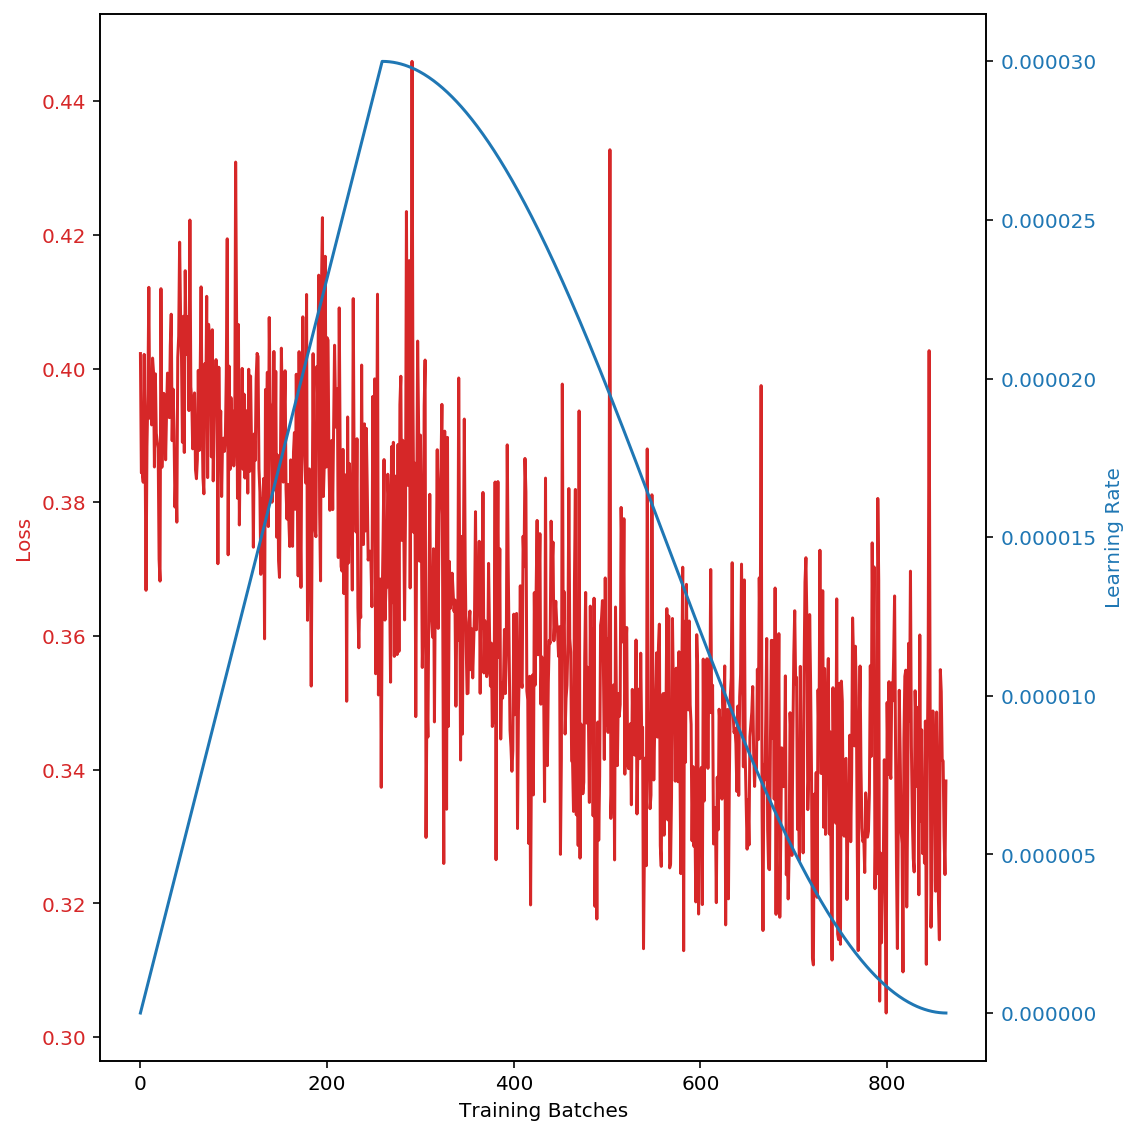

,id,proba,label
898,59031,0.350,0
659,85317,0.359,0
222,13907,0.372,0
620,58716,0.442,0
552,16473,0.334,0


In [14]:
epochs = 24
submission, text_model = train_and_predict((model, optimizer), data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 34, 42, 46],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
